# Sphincs+ algorithm

In [1]:
from math import ceil, floor, log2
from copy import deepcopy
from hashlib import sha256
import hmac
from cryptography.hazmat.primitives import hashes
from cryptography.hazmat.primitives.asymmetric import padding

## Useful functions

In [2]:
def rot_left(n, d):
    return (n << d)|(n >> (32 - d)) & 0xFFFFFFFF

def rot_right(n, d):
    return (n >> d)|(n << (32 - d)) & 0xFFFFFFFF

A byte string can be considered as a string of base w numbers, i.e. integers in the set {0, . . . , w−
1}. The correspondence is defined by the function base_w(X, w, out_len) as follows. Let X be
a len_X- byte string, and w is an element of the set {4, 16, 256}, then base_w(X, w, out_len)
outputs an array of out_len integers between 0 and w − 1 (Figure 1). The length out_len is
REQUIRED to be less than or equal to 8 ∗ len_X/ log(w).

In [3]:
def base_w(X, w, out_len):
    i = 0
    total = 0
    bits = 0
    basew = []
    for consumed in range(out_len):
        if bits == 0:
            total = X[i]
            i += 1
            bits += 8
        bits -= int(log2(w))
        basew.append(rot_right(total, bits) & (w-1))
    return basew

base_w(b'\x12\x34', 16, 4)

[1, 2, 3, 4]

In [4]:
def xor(a, b):
    return bytearray([a[i] ^ b[i] for i in range(len(a))])

In [5]:
def num_to_bytes(num, length=8):
    return int.to_bytes(num, length=length, byteorder='big')

## Hash Functions

<font color='red'>TODO: Shorter Outputs. If a parameter set requires an output length n < 32-bytes for F, H, PRF,and PRFmsg we take the first n bytes of the output and discard the remaining.</font>


In [6]:
def MGF1(m, size, h=sha256):
    hlen = 32
    output = bytearray()
    for i in range(0, ceil(size/hlen)):
        ibytes = i.to_bytes(4, 'big')
        tmp = h(m + ibytes).digest()
        output = output + tmp
    return output[: size + 1]

In [7]:
def generate_mask(m, pk_seed, adrs, mask_len):
    m_arr = bytearray(m)
    mask = MGF1(pk_seed + adrs, mask_len)
    return xor(m_arr,mask)

In [8]:
import os
arr = bytearray([0, 0, 1, 0, 0, 0, 0, 0])
pk_seed = os.urandom(32)
mask_len = 32
test_m = ('t'*32).encode('utf-8')

generate_mask(test_m, pk_seed, arr, mask_len)

bytearray(b'wz\xdc\xba\x0e]\xfb\xce\xda\x0c\xe0R\xd4\xf26\x8d\x0e\x82\xce<\x9f|\xf7h\xf8.\n\xd8t\xd2\xc5H')

In [9]:
def F(pk_seed, adrs, m1):
    mask = generate_mask(m1, pk_seed, adrs, len(m1))
    mess = pk_seed + adrs + mask
    return sha256(mess).digest()

In [10]:
F(pk_seed, arr, test_m)

b'\x9b\xeaH\xcf0^\xda9\xc0\xafD`\xef\xf6\xb3\x9d\xab\xdfk\xf3X0\x91\xca\x1c\xe4^\xf5\xdf}\xd0\x96'

In [11]:
def H(pk_seed, adrs, m1, m2):
    mask1 = generate_mask(m1, pk_seed, adrs, len(m1))
    mask2 = generate_mask(m2, pk_seed, adrs, len(m2))
    mess = pk_seed + adrs + mask1 + mask2
    return sha256(mess).digest()

H(pk_seed, arr, test_m, test_m[:-1] + b'u')

b'\xd2\x89\x82\xd3\xed\xfcRqS\x93\xbe56\xf5E\x97;]\xd4C\x9bl\xa5e>\xa2\x95\xbb\xe0X\xc2\xcf'

In [12]:
def H_msg(r, pk_seed, pk_root, m):
    mess = r + pk_seed + pk_root + m
    sha = sha256(mess).digest()
    return MGF1(sha, len(m))

In [13]:
def PRF(seed, adrs):
    mess = seed + adrs
    return sha256(mess).digest()

In [14]:
def PRF_msg(sk_seed, sk_prf, opt_rand, m):
    hmac_value = hmac.new(sk_prf, opt_rand + m , sha256)
    return hmac_value.digest()

## WOTS+

Parameters:
* n - the security parameter - it is the message length as well as the length of a private key, public key, or signature element in bytes
* w - the Winternitz parameter; it is an element of the set {4, 16, 256}

These parameters are used to compute values _len_, _len1_ and _len2_:

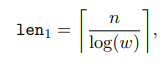

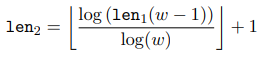



In [15]:
n = 32
w = 16
h = 64
len1 = ceil(n/log2(w))
len2 = floor(log2(len1*(w-1))/log2(w)) + 1
length = len1 + len2
print(len1, len2, length)

8 2 10


### Chaining Function

In [16]:
def chain(X, i, s, pk_seed, adrs):
    if s == 0:
        return X, adrs
    if i+s > w-1:
        return None, adrs
    tmp, adrs = chain(X, i, s-1, pk_seed, adrs)
    adrs[-8:] = num_to_bytes(i + s - 1) # hash address
    tmp = F(pk_seed, adrs, tmp)
    return tmp, adrs

### Private key generation

In [17]:
def wots_SKgen(sk_seed, adrs, length):
    sk = bytearray()
    for i in range(length):
        adrs[16:24] = num_to_bytes(i) # chain address
        sk += PRF(sk_seed, adrs)
    return sk, adrs

### Public key generation

In [18]:
def wots_PKgen(sk_seed, pk_seed, adrs):
    wotspkadrs = deepcopy(adrs)
    tmp = bytearray()
    for i in range(length):
        adrs[16:24] = num_to_bytes(i) # chain address
        sk = PRF(sk_seed, adrs)
        chain_res, adrs = chain(bytearray(sk[i]), 0, w-1, pk_seed, adrs)
        tmp += chain_res
    wotspkadrs[:8] = num_to_bytes(1) # set type to WOTS_PK
    wotspkadrs[8:16] = deepcopy(adrs[8:16]) # key pair
    pk = sha256(pk_seed + wotspkadrs + tmp).digest()
    return pk, adrs

### Signature Generation

In [19]:
def wots_sign(m, sk_seed, pk_seed, adrs, len1):
    csum = 0
    
    # convert message to base w
    msg = base_w(m, w, len1)
    
    # compute checksum
    for i in range(len1):
        csum += w - 1 - msg[i]
    
    # convert csum to base w
    csum = rot_left(csum, (8 - ((len2 * int(log2(w)) % 8))))
    msg = msg + base_w(num_to_bytes(csum), w, len2)
    sig = bytearray()
    for i in range(length):
        adrs[16:24] = num_to_bytes(i) # chain
        sk = PRF(sk_seed, adrs)
        tmp, adrs = chain(sk, 0, msg[i], pk_seed, adrs)
        sig = sig + tmp
    return sig, adrs

### Compute Public Key from Signature

In [20]:
def wots_pk_from_sig(sig, m, pk_seed, adrs):
    csum = 0
    wotspkadrs = deepcopy(adrs)
    
    # convert message to base w
    msg = base_w(m, w, len1)
    
    # compute checksum
    for i in range(len1):
        csum += w - 1 - msg[i]
        
    # convert csum to base w
    csum = rot_left(csum, ( 8 - ( ( len2 * int(log2(w)) ) % 8 )))
    msg += base_w(num_to_bytes(csum), w, len2)
    tmp = bytearray()
    for i in range(length):
        adrs[16:24] = num_to_bytes(i) # chain
        t, adrs = chain(bytearray(sig[i]), msg[i], w - 1 - msg[i], pk_seed, adrs);
        tmp += t
    wotspkadrs[:8] = num_to_bytes(1)
    wotspkadrs[8:16] = deepcopy(adrs[8:16])
    pk_sig = sha256(pk_seed + wotspkadrs + tmp).digest()
    return pk_sig, adrs


In [21]:
# generate keys
SK_SEED = bytearray(os.urandom(n))
PK_SEED = bytearray(os.urandom(n))
ADRS = bytearray(os.urandom(32))
M = bytearray(b"Ala ma kotka a kotek ma tez Ale!")
print(len(M))

wots_sk, adrs = wots_SKgen(SK_SEED, ADRS, length)
wots_pk, adrs = wots_PKgen(SK_SEED, PK_SEED, adrs)

# generate a signature
wots_sig, adrs = wots_sign(M, wots_sk, wots_pk, adrs, len1)

# compare public keys
wots_pk_from_sig(wots_sig, M, PK_SEED, adrs)[0]

32


b"\xeczS\xd1'\xab\x03\x9b\xcf\xae\x96\xc5O\xbb\xd8%N\xe5\x92\x87k3e\x9cY\x15\xfe\x1d\xeaI\xady"

In [24]:
wots_sig

bytearray(b'\x94\x80UKJ\xf7\xab\xb1\x9b\x8a\xabN\xe1`\xb6\xe1\x88\xe4\x92\xe7\x19n\xd7W\x01\x04G\x02\xfbY\xd5\x81\x8a3\x8c\xf5\r\x1c,e\xc4\xf3~\x01\x10\xa0\xd7\xa8c<\xa1\xef0\x13o eBw\xba\xa4A\x7fQ\x02\xfc\xb3\xa0\x0bE\xbb\x7f_E]C5b\xc4Sd\xac5X\x8d\xbd\xf4\xd2\xf2\xf8F\x17\xe1`\x81\x92\xb5\xeb\x14G\xadR\xfe\x8bK\x8f\xe8\x14\xa4\x16,\xe5\x9eD%\xb6\x13\xfdA\x03\xe4\xf3\xf0"Zm\xf2\x17\x04\x14\x04\xc4\xc5!\x97\x7f2\x073PaSD^\xb4i4\xe0tAS\x14\xeaTaQ\xcb3)\xf6\x18\xfe\xac\xdf\xab\xe3wJ*\x17\x11\xd6\x06\x13$\xf0h\x11\xb3\xa8sa\x0b8\xef\x06\xf2\xeat\x00\x1ax\x9b\x02|\x17]\xa7WBo\xa5\x9f%\x9fu\xc7!j\x8e\xf7j\rT\xf1\xc1\\s\xbeg7\xd3\xba\xa8\x19v\n]\x1d\xbc\xff\x86\xc4\xed\xe1\xaea\xe5\x81\x9c:\xbdy_]$\xd0i\xdf\xc68\x984\x8f\xfd\xbc\'\xa4&\xe2\x85\xb6\x1f\xfa%\x93\x7ffb\xb0\x1b\xcfo\x9a\xe3\xec\xc8\xb8\x07F$\x80\x0e\\\xacz\x8eb\xfd\xad\x80\x85|\xba\r\xa8\x87\x16\xad\xbfz\x1d\xe3\x1e\xf7~\xd6I\xb3?\xa4A\x0c\x18NK#b\xda\xbc')

In [22]:
wots_pk

b'\xfbaT\x03\xb4\x8f\xa4\xf4\xc0\xa8w\xa4\x81M\x1c\x92\xf6\x9f\x1a\x99!\xa6\xb8\xa4sa\xa0#"\x97\x9a\x02'

## XMSS

Parameters:
* h' - the height (number of levels - 1) of the tree
* n - the length in bytes of messages as well as of each node
* w - the Winternitz parameter as defined for WOTS+

In [30]:
def node_height(node):
    pass

### Treehash algorithm

<font color='red'>It is REQUIRED that s % 2z = 0, i.e. that the leaf at index s is a leftmost leaf of a sub-tree of height z. Otherwise the algorithm fails as it would compute non-existent nodes

In [51]:
def treehash(sk_seed, s, z, pk_seed, adrs, stack):
    if s % rot_left(1, z) != 0:
        return -1
        
    for i in range(pow(2,z)):
        adrs[:8] = num_to_bytes(0) # wots hash
        adrs[8:16] = num_to_bytes(s+i) # key pair
        node, adrs = wots_PKgen(sk_seed, pk_seed, adrs)
        adrs[:8] = num_to_bytes(2) # tree type
        adrs[16:24] = num_to_bytes(1) # tree height
        adrs[24:] = num_to_bytes(s+i) # tree index
        while node_height(stack[0]) == node_height(node):
            adrs[24:] = num_to_bytes((int.from_bytes(adrs[16:24], 'big') - 1 // 2))
            node = H(pk_seed, adrs, stack.pop() + node)
            adrs[16:24] = num_to_bytes((int.from_bytes(adrs[16:24], 'big') + 1))
        stack.append(node)
    return stack.pop(), adrs

<font color='red'>CO TO JEST STACK I GDZIE GO ZADEKLAROWAC?

### XMSS Public Key Generation

In [32]:
def xmss_PKgen(sk_seed, pk_seed, adrs):
    pk, adrs = treehash(sk_seed, 0, h_prim, pk_seed, adrs)
    return pk, adrs

### XMSS Signature

In [53]:
def  xmss_sign(m, sk_seed, idx, pk_seed, adrs):
    # build authentication path
    auth = bytearray()
    for j in range(h_prim):
        k = floor(idx/pow(2,j)) ^ 1
        auth_j, adrs = treehash(sk_seed, k*pow(2,j), j, pk_seed, adrs)
        auth += auth_j
    adrs[:8] = num_to_bytes(0)
    adrs[8:16] = num_to_bytes(idx) # key pair
    sig, adrs = wots_sign(m, sk_seed, pk_seed, adrs)
    sig_xmss = sig + auth
    return sig_xmss, adrs

### XMSS Compute Public Key from Signature

In [54]:
def xmss_pk_from_sig(idx, sig_xmss, m, pk_seed, adrs):
    # compute wots+ pk from wots+ sig
    adrs[:8] = num_to_bytes(0)
    adrs[8:16] = num_to_bytes(idx)
    sig = sig_xmss[:len*n]
    auth = sig_xmss[len*n:]
    node = []
    n, adrs = wots_pk_from_sig(sig, m, pk_seed, adrs)
    node[0] = n
    
    # compute root from wots+ pk and auth
    adrs[:8] = num_to_bytes(2)
    adrs[-8:] = num_to_bytes(idx)
    for k in range(h_prim):
        adrs[16:24] = num_to_bytes(k+1)
        if floor(idx/pow(2,k)) % 2 == 0:
            adrs[-8:] = num_to_bytes(int.from_bytes(adrs[-8:], 'big') // 2)
            node[1] = H(pk_seed, adrs, auth[k] + node[0])
        else:
            adrs[-8:] = num_to_bytes((int.from_bytes(adrs[-8:], 'big') - 1) // 2)
            node[1] = H(pk_seed, adrs, auth[k] + node[0])
        node[0] = node[1]
    return node[0], adrs

## Hypertree

Parameters:
* h - hypertree height
* d - number of tree layers

### HT Key Generation

In [38]:
def ht_pk_gen(sk_seed, pk_seed):
    adrs = int_to_byte(0, length=32)
    adrs[:8] = num_to_byte(d-1)
    root, adrs = xmss_pk_gen(sk_seed, pk_seed, adrs)
    return root, adrs

### HT signature

In [57]:
def ht_sign(m, sk_seed, pk_seed, idx_tree, idx_leaf):
    # init
    adrs = int_to_byte(0, length=32)
    
    # sign
    adrs[:8] = num_to_byte(0)
    adrs[8:] = idx_tree
    sig_tmp, adrs = xmss_sign(m, sk_seed, idx_leaf, pk_seed, adrs)
    sig_ht = bytearray()
    sig_ht += sig_tmp
    root, adrs = xmss_pk_from_sig(idx_leaf, sig_tmp, m, pk_seed, adrs)
    for j in range(1, d):
        idx_leaf = idx_tree[-(h/d):] # least significant bits of idx_tree
        idx_tree = idx_tree[:(h-j * (h/d))] # most significant bits of idx_tree
        adrs[:8] = num_to_int(j)
        adrs[8:] = idx_tree
        sig_tmp, adrs = xmss_sign(root, sk_seed, idx_leaf, pk_seed, adrs)
        sig_ht += sig_tmp
        if j < d - 1:
            root, adrs = xmss_pk_from_sig(idx_leaf, sig_tmp, root, pk_seed, adrs)
    return sig_ht, adrs
    

### HT Signature Verification

In [47]:
def ht_verify(m, sig_ht, pk_seed, idx_tree, idx_leaf, pk_ht):
    # init
    adrs = int_to_byte(0, length=32)
    
    # verify
    sig_tmp = sig_ht[0] # first xmss_sig
    adrs[:8] = num_to_bytes(0)
    adrs[8:] = num_to_bytes(idx_tree)
    node, adrs = xmss_pk_from_sig(idx_leaf, sig_tmp, m, pk_seed, adrs)
    for j in range(1, d):
        idx_leaf = idx[-(h//d):]  # least significant bits of idx
        idx_tree = idx[:(h-j * h // d)] #  most significant bits of idx
        sig_tmp, adrs = sig_ht[j]
        adrs[:8] = num_to_bytes(j)
        adrs[8:] = num_to_bytes(idx_tree)
        node, adrs = xmss_pk_from_sig(idx_leaf, sig_tmp, node, pk_seed, adrs)
    if node == pk_ht:
        return True, adrs
    return False, adrs

## FORS: Forest Of Random Subsets

Parameters:
* n - the security parameter; it is the length of a private key, public key, or signature element in bytes.
* k - the number of private key sets, trees and indices computed from the input string.
* t - the number of elements per private key set, number of leaves per hash tree and upper bound on the index values. The parameter t MUST be a power of 2. If t = 2a, then the trees have height a and the input string is split into bit strings of length a.

### FORS Private Key

In [48]:
def fors_sk_gen(sk_seed, adrs, idx):
    adrs[16:24] = num_to_bytes(0)
    adrs[-8:] = num_to_bytes(idx)
    sk = PRF(sk_seed, adrs)
    return sk, adrs

### FORS Tree Hash

<font color='red'>CO TO JEST STACK I GDZIE GO ZADEKLAROWAC?

In [55]:
def fors_treehash(sk_seed, s, z, pk_seed, adrs, stack):
    if s % rot_left(1, z) != 0:
        return -1
    for i in range(pow(2,z)):
        adrs[16:24] = num_to_bytes(0)
        adrs[-8:] = num_to_bytes(s + i)
        sk = PRF(sk_seed, adrs)
        node = F(pk_seed, adrs, sk)
        adrs[16:24] = num_to_bytes(1)
        while node_height(stack[0]) == node_height(node):
            adrs[-8:] = num_to_bytes((int.from_bytes(adrs[-8:], 'big') - 1) // 2)
            node = H(pk_seed, adrs, stack.pop() + node)
        stack.push(node)
    return stack.pop(), adrs

### FORS Public Key

In [50]:
def fors_pkgen(sk_seed, pk_seed, adrs):
    forspkadrs = deepcopy(adrs)
    root = []
    for i in range(k):
        r, adrs = fors_treehash(sk_seed, i*k, a, pk_seed, adrs)
        root.append(r)
    forspkadrs[:8] = num_to_int(4)
    forspkadrs[8:16] = adrs[8:16]
    pk = sha256(pk_seed + forspkadrs + root).digest() # ???
    return pk, adrs

### FORS Signature Generation

In [56]:
def fors_sign(m, sk_seed, pk_seed, adrs):
    # compute signature elements
    sig_fors = bytearray()
    for i in range(k):
        # get next index
        idx = m[i*t-1 : (i+1)*t - 2] # ?? - bits i*t to (i+1)*t - 1 of M
        
        # pick private key element
        adrs[16:24] = num_to_int(0)
        adrs[-8:] = i*t + idx
        sig_fors += PRF(sk_seed, adrs)
        
        # compute auth path
        auth = bytearray()
        for j in range(a):
            s = floor(idx/(pow(2, j))) ^ 1
            a, adrs = fors_treehash(sk_seed, i*k + s * pow(2,j), j, pk_seed, adrs)
            auth += a
        sig_fors = sig_fors + auth
    return sig_fors, adrs

### FORS Compute Public Key from Signature

In [61]:
def fors_pk_from_sig(sig_fors, m, pk_seed, adrs):
    # compute roots
    root = bytearray()
    for i in range(k):
        # get next index
        idx = m[i*t - 1 : (i+1)*t - 2]  # ?? bits i*t to (i+1)*t - 1 of M
        
        # compute leaf
        sk = sig_fors[i * (log2(t)*n + n)] # SK[i]
        adrs[16:24] = num_to_bytes(0)
        adrs[-8:] = num_to_bytes(i*t + idx)
        node = [F(pk_seed, adrs, sk)]
        
        # compute root from leaf and AUTH
        auth = sig_fors[i * (log2(t)*n + n) + n]
        adrs[-8:] = idx
        for j in range(int(log2(t))): # a = log(t)
            adrs[16:24] = num_to_bytes(j+1)
            if floor(idx/pow(2,j)) % 2 == 0:
                adrs[-8:] = num_to_bytes(int.from_bytes(adrs[-8:]) // 2)
                node.append(H(pk_seed, adrs, node[0] + auth[j]))
            else:
                adrs[-8:] = num_to_bytes((int.from_bytes(adrs[-8:]) - 1) // 2)
                node.append(H(pk_seed, adrs, auth[j] + node[0]))
            node[0] = node[1]
        root += node[0]
    forspkadrs = deepcopy(adrs)
    forspkadrs[:8] = num_to_bytes(4)
    pk = sha256(pk_seed, forspkadrs, root).digest()
    return pk, adrs

## SPHINCS+

Parameters:
* n - the security parameter in bytes.
* w - the Winternitz parameter
* h - the height of the hypertree
* d - the number of layers in the hypertree
* k - the number of trees in FORS
* t - the number of leaves of a FORS tree

### SPHINCS+ Key Generation

In [60]:
def spx_keygen():
    pk_seed = bytearray(os.urandom(n))
    sk_prf = bytearray(os.urandom(n))
    pk_seed = bytearray(os.urandom(n))
    pk_root, adrs = ht_pk_gen(sk_seed, pk_seed)
    return sk_seed, sk_prf, pk_seed, pk_root, pk_seed, pk_root

### SPHINCS+ Signature

In [62]:
def spx_sign(m, sk_seed, sk_prf, pk_seed, pk_root):
    # init
    adrs = bytearray(32)
    
    # generate randomizer
    opt = bytearray(32)
    r = PRF_msg(sk_prf, opt, m)
    sig = r
    
    # compute message digest and index
    digest = H_msg(r, pk_seed, pk_root, m)
    tmp_md = digest[:floor((k*a + 7)/8)] # first floor((ka +7)/ 8) bytes of digest;
    tmp_idx_tree = digest[floor((k*a + 7)/8) : floor((k*a + 7)/8) + floor((h - h/d +7)/ 8)] # next floor((h - h/d +7)/ 8) bytes of digest;
    tmp_idx_leaf = digest[floor((k*a + 7)/8) + floor((h - h/d +7)/ 8):] # next floor((h/d +7)/ 8) bytes of digest;
    
    md = tmp_md[:k*a] # first ka bits of tmp_md;
    idx_tree = tmp_idx_tree[:(h-h/d)] # first h - h/d bits of tmp_idx_tree;
    idx_leaf = tmp_idx[:h//d] # first h/d bits of tmp_idx_leaf;
    
    # FORS sign
    adrs[:8] = num_to_bytes(3)
    adrs[8:] = idx_tree
    adrs[8:16] = idx_leaf
    
    sig_fors, adrs = fors_sign(md, sk_seed, pk_seed, adrs)
    sig = sig_fors
    
    # get FORS public key
    pk_fors = fors_pk_from_sig(sig_fors, m, pk_seed, adrs)
    
    # sign FORS public key with HT
    adrs[:8] = num_to_bytes(2)
    sig_ht, adrs = ht_sign(pk_fors, sk_seed, pk_seed, idx_tree, idx_leaf)
    sig += sig_ht
    return sig